# Final Figures and Tables

This notebook aggregates results from stages 1, 2, 2.5, 3, and 3.5 into summary tables.

In [37]:
from pathlib import Path
import os
import pandas as pd

%matplotlib inline

# Detect project root: prefer PROJ_ROOT env, else repo root (parent if running from notebooks/)
cwd = Path.cwd().expanduser().resolve()
default_root = cwd.parent if cwd.name == 'notebooks' else cwd
PROJ_ROOT = Path(os.environ.get('PROJ_ROOT', default_root)).expanduser().resolve()
EXP = PROJ_ROOT / 'experiments'
print('Project root:', PROJ_ROOT)
print('Experiments dir:', EXP)


Project root: /home/milos/dev/ese-3060-project
Experiments dir: /home/milos/dev/ese-3060-project/experiments


In [38]:
# Load available stage-specific result files
def load_csv(path):
    return pd.read_csv(path) if path.exists() else pd.DataFrame()
results_all = load_csv(EXP / 'results.csv')
r_stage1 = load_csv(EXP / 'results_stage1.csv')
r_stage2 = load_csv(EXP / 'results_stage2.csv')
r_stage25 = load_csv(EXP / 'results_stage2_5.csv')
r_stage3 = load_csv(EXP / 'results_stage3.csv') if (EXP / 'results_stage3.csv').exists() else load_csv(EXP / 'results_stage_3.csv')
r_stage35 = load_csv(EXP / 'baseline.csv')  # stage3.5 baseline export
print('Loaded shapes:', {'stage1': r_stage1.shape, 'stage2': r_stage2.shape, 'stage2.5': r_stage25.shape, 'stage3': r_stage3.shape, 'stage3.5': r_stage35.shape})


Loaded shapes: {'stage1': (10, 21), 'stage2': (16, 21), 'stage2.5': (4, 21), 'stage3': (6, 21), 'stage3.5': (1, 10)}


In [39]:
# Helper: convert ms to minutes:seconds string
def ms_to_min_sec(ms):
    if pd.isna(ms):
        return 'NA'
    minutes = int(ms // 60000)
    seconds = (ms % 60000) / 1000.0
    return f"{minutes}m {seconds:.1f}s"


## Stage 1 Results

In [40]:
# 1) Stage 1 table: gate type, gate_act (function), seeds, final loss, train time (mm:ss)
stage1_source = r_stage1 if not r_stage1.empty else results_all[results_all.get('num_iterations',0) <= 2000]
if not stage1_source.empty:
    tbl1 = stage1_source.groupby(['attn_gate','gate_act']).agg(
        seeds=('run_id','count'),
        final_loss=('final_val_loss','mean'),
        train_time_ms=('train_time_ms','mean'),
    ).reset_index()
    tbl1['train_time'] = tbl1['train_time_ms'].apply(ms_to_min_sec)
    tbl1 = tbl1[['attn_gate','gate_act','seeds','final_loss','train_time']]
    display(tbl1)
else:
    print('Stage 1 results not found.')


,attn_gate,gate_act,seeds,final_loss,train_time
0,const,sigmoid,2,3.538315,10m 9.1s
1,elementwise,sigmoid,2,3.515899,10m 31.0s
2,headwise,ns_sigmoid,2,3.527213,10m 11.4s
3,headwise,sigmoid,2,3.531157,10m 15.7s
4,none,sigmoid,2,3.533365,9m 52.9s


In [41]:
# 2) Stage 2 table: gate type, lr, final loss, train time
tbl2_stage2 = []
if not r_stage2.empty:
    part = r_stage2.groupby(['attn_gate','learning_rate']).agg(
        final_loss=('final_val_loss','mean'),
        train_time_ms=('train_time_ms','mean'),
    ).reset_index()
    part['train_time'] = part['train_time_ms'].apply(ms_to_min_sec)
    tbl2_stage2.append(part[['attn_gate','learning_rate','final_loss','train_time']])
if tbl2_stage2:
    tbl2 = pd.concat(tbl2_stage2, ignore_index=True)
    display(tbl2)
else:
    print('Stage 2 results not found.')


,attn_gate,learning_rate,final_loss,train_time
0,elementwise,0.00360,3.934880,5m 35.7s
1,elementwise,0.00396,3.911479,5m 32.5s
2,elementwise,0.00432,3.891968,5m 31.9s
3,elementwise,0.00468,3.874321,5m 34.6s
4,none,0.00360,3.916711,5m 14.5s
5,none,0.00396,3.896397,5m 14.6s
6,none,0.00432,3.879807,5m 13.2s
7,none,0.00468,3.864021,5m 15.3s


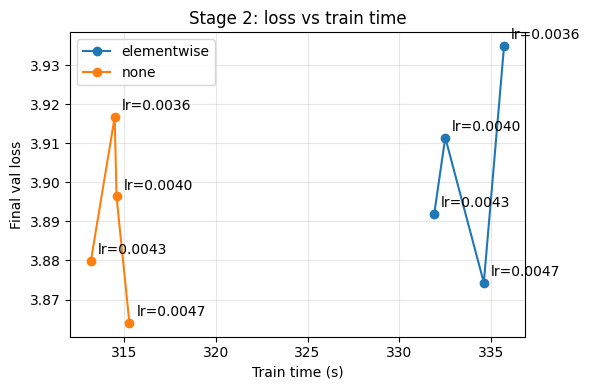

In [42]:
import matplotlib.pyplot as plt
import re

# Stage 2 line plot: final loss vs train time, colored by gate, lr labels
if 'tbl2' in locals() and not tbl2.empty:
    def parse_time_series(df):
        if 'train_time_ms' in df.columns:
            return df['train_time_ms'] / 1000.0
        if 'train_time' in df.columns:
            def to_seconds(s):
                if pd.isna(s):
                    return None
                s = str(s)
                m = re.search(r'(?P<m>\d+(?:\.\d+)?)m', s)
                sec = re.search(r'(?P<s>\d+(?:\.\d+)?)s', s)
                total = 0.0
                if m:
                    total += float(m.group('m')) * 60.0
                if sec:
                    total += float(sec.group('s'))
                return total if total > 0 else None
            return df['train_time'].apply(to_seconds)
        return pd.Series([None]*len(df))

    fig, ax = plt.subplots(figsize=(6,4))
    for gate, sub in tbl2.groupby('attn_gate'):
        tt = parse_time_series(sub)
        sub = sub.assign(tt=tt).dropna(subset=['tt']).sort_values('tt')
        ax.plot(sub['tt'], sub['final_loss'], marker='o', label=gate)
        for _, row in sub.iterrows():
            lbl = f"lr={row['learning_rate']:.4f}"
            ax.annotate(lbl, (row['tt'], row['final_loss']), textcoords='offset points', xytext=(5,5), ha='left')
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Final val loss')
    ax.set_title('Stage 2: loss vs train time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('No Stage 2 data to plot.')


## Stage 2.5 Results

In [43]:
# Stage 2.5 table: gate type, lr, final loss, train time
if not r_stage25.empty:
    part = r_stage25.groupby(['attn_gate','learning_rate']).agg(
        final_loss=('final_val_loss','mean'),
        train_time_ms=('train_time_ms','mean'),
    ).reset_index()
    part['train_time'] = part['train_time_ms'].apply(ms_to_min_sec)
    part = part[['attn_gate','learning_rate','final_loss','train_time']]
    display(part)
else:
    print('Stage 2.5 results not found.')


,attn_gate,learning_rate,final_loss,train_time
0,elementwise,0.00468,3.509918,10m 29.8s
1,none,0.00468,3.529808,9m 56.8s


## Stage 3/3.5 Results

In [44]:
# 3) Stage 3/3.5 table: gate type, learning rate, seeds, final loss, train time (mm:ss)
tbl3_parts = []
if not r_stage3.empty:
    part = r_stage3.groupby(['attn_gate','learning_rate']).agg(
        seeds=('run_id','count'),
        final_loss=('final_val_loss','mean'),
        train_time_ms=('train_time_ms','mean'),
    ).reset_index()
    part['train_time'] = part['train_time_ms'].apply(ms_to_min_sec)
    tbl3_parts.append(part[['attn_gate','learning_rate','seeds','final_loss','train_time']])
if not r_stage35.empty:
    part = r_stage35.copy()
    # ensure required columns exist
    if 'learning_rate' not in part.columns:
        part['learning_rate'] = part.get('lr', None)
    if 'final_val_loss' in part.columns and 'final_loss' not in part.columns:
        part['final_loss'] = part['final_val_loss']
    if 'train_time_ms' in part.columns:
        part['train_time'] = part['train_time_ms'].apply(ms_to_min_sec)
    else:
        part['train_time'] = 'NA'
    if 'seeds' not in part.columns:
        part['seeds'] = 1
    tbl3_parts.append(part[['attn_gate','learning_rate','seeds','final_loss','train_time']])
if tbl3_parts:
    tbl3 = pd.concat(tbl3_parts, ignore_index=True)
    display(tbl3)
else:
    print('Stage 3/3.5 results not found.')


,attn_gate,learning_rate,seeds,final_loss,train_time
0,elementwise,0.00468,3,3.272271,26m 10.9s
1,none,0.00468,3,3.292699,24m 36.9s
2,none,0.00360,1,3.293800,24m 36.9s


In [45]:
# Export tables to experiments/tables
tables_dir = PROJ_ROOT / 'experiments' / 'tables'
tables_dir.mkdir(parents=True, exist_ok=True)
# stage1
if 'tbl1' in locals():
    tbl1.to_csv(tables_dir / 'stage1.csv', index=False)
# stage2
if 'tbl2' in locals():
    tbl2.to_csv(tables_dir / 'stage2.csv', index=False)
# stage2.5 recompute from r_stage25 to be safe
if 'r_stage25' in locals() and not r_stage25.empty:
    tbl2_5 = r_stage25.groupby(['attn_gate','learning_rate','num_iterations']).agg(
        final_loss=('final_val_loss','mean'),
        train_time_ms=('train_time_ms','mean'),
    ).reset_index()
    tbl2_5['train_time'] = tbl2_5['train_time_ms'].apply(ms_to_min_sec)
    tbl2_5 = tbl2_5[['attn_gate','learning_rate','num_iterations','final_loss','train_time']]
    tbl2_5.to_csv(tables_dir / 'stage2_5.csv', index=False)
# stage3
if 'tbl3' in locals():
    tbl3.to_csv(tables_dir / 'stage3.csv', index=False)
print('Exported tables to', tables_dir)


Exported tables to /home/milos/dev/ese-3060-project/experiments/tables
